# Training

- load best parameters from hyperparameter tuning
- load data and prepare for training
- fit and save model

### Setup

In [1]:
import sys
sys.path.append('../')
from src.load_data import *
from src.realtime_utils import *
from src.plot_functions import *
from src.hp_tuning_functions import *
import torch
from darts.utils.likelihood_models import NegativeBinomialLikelihood
from pytorch_lightning.callbacks import RichProgressBar

In [2]:
from darts.models import TSMixerModel

/home/wolffram/.conda/envs/RESPINOW-ML/lib/python3.9/site-packages/statsforecast/utils.py:231: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.


In [3]:
import wandb
wandb.login()

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Using wandb-core as the SDK backend. Please refer to https://wandb.me/wandb-core for more information.
wandb: Currently logged in as: dwolffram (dwolffram-karlsruhe-institute-of-technology). Use `wandb login --relogin` to force relogin


True

### Configuration

In [4]:
NUM_SAMPLES = 1000
HORIZON = 4

ENCODERS = {
    'datetime_attribute': {'future': ['month', 'weekofyear']}
}

SHARED_ARGS = dict(
    output_chunk_length=HORIZON,
    likelihood=NegativeBinomialLikelihood(),
    pl_trainer_kwargs={
       "enable_progress_bar" : True,
       "enable_model_summary" : False,
       "accelerator" : "cpu",
       "callbacks" : [RichProgressBar(leave=True)]
    }
)

OPTIMIZER_DICT = {
    "Adam" : torch.optim.Adam,
    "AdamW" : torch.optim.AdamW,
    "SGD": torch.optim.SGD
}

# Load best model

In [5]:
params = get_best_parameters('tsmixer-multiple-runs', 'tsmixer')

WIS of best run: 227.89906656948497


In [6]:
params

{'model': 'tsmixer',
 'dropout': 0.2,
 'ff_size': 16,
 'n_epochs': 500,
 'norm_type': 'TimeBatchNorm2d',
 'optimizer': 'AdamW',
 'test_year': 2019,
 'activation': 'ReLU',
 'batch_size': 8,
 'num_blocks': 4,
 'hidden_size': 16,
 'use_encoders': True,
 'use_features': False,
 'use_covariates': True,
 'normalize_before': False,
 'optimizer_kwargs': {'lr': 0.01, 'weight_decay': 0.0001},
 'input_chunk_length': 8,
 'use_static_covariates': False}

In [7]:
name = params.pop('model')
test_year = params.pop('test_year')
use_covariates = params.pop('use_covariates')
use_features = params.pop('use_features')
use_encoders = params.pop('use_encoders')
optimizer = params.pop('optimizer')

params['optimizer_cls'] = OPTIMIZER_DICT[optimizer]

if not use_covariates:
    del params['lags_past_covariates']

In [8]:
model = TSMixerModel(
    **params,
    add_encoders=ENCODERS if use_encoders else None,
    **SHARED_ARGS
)

# Load data

In [9]:
current_date = pd.Timestamp.now().date()

In [10]:
rt = load_rt()

In [11]:
target = target_as_of(rt, current_date)

In [12]:
target

,location,age_group,year,week,date,value
0,DE,00+,2022,52,2023-01-01,25744.0
1,DE,00+,2023,1,2023-01-08,21971.0
2,DE,00+,2023,2,2023-01-15,13644.0
3,DE,00+,2023,3,2023-01-22,11145.0
4,DE,00+,2023,4,2023-01-29,11322.0
...,...,...,...,...,...,...
625,DE,80+,2024,33,2024-08-18,2854.0
626,DE,80+,2024,34,2024-08-25,2818.0
627,DE,80+,2024,35,2024-09-01,2741.0
628,DE,80+,2024,36,2024-09-08,2610.0


In [16]:
t

,location,age_group,year,week,date,value
0,DE,00+,2022,52,2023-01-01,25744
1,DE,00+,2023,1,2023-01-08,21971
2,DE,00+,2023,2,2023-01-15,13644
3,DE,00+,2023,3,2023-01-22,11145
4,DE,00+,2023,4,2023-01-29,11322
...,...,...,...,...,...,...
625,DE,80+,2024,33,2024-08-18,2854
626,DE,80+,2024,34,2024-08-25,2818
627,DE,80+,2024,35,2024-09-01,2741
628,DE,80+,2024,36,2024-09-08,2610


In [13]:
t = pd.read_csv('https://raw.githubusercontent.com/KITmetricslab/RESPINOW-Hub/refs/heads/main/data/icosari/sari/target-icosari-sari.csv')

In [17]:
all(t.value.astype(int) == target.value.astype(int))

True

In [18]:
SEASON_DICT

{2014: Timestamp('2015-09-27 00:00:00'),
 2015: Timestamp('2016-10-02 00:00:00'),
 2016: Timestamp('2017-10-01 00:00:00'),
 2017: Timestamp('2018-09-30 00:00:00'),
 2018: Timestamp('2019-09-29 00:00:00'),
 2019: Timestamp('2020-09-27 00:00:00')}

In [20]:
pd.to_datetime(Week(2023 + 1, 39, system="iso").enddate())

Timestamp('2024-09-29 00:00:00')

In [11]:
sources =  ['icosari', 'agi']

In [13]:
targets_train, targets_validation, covariates = get_test_data(2019, sources)

<Axes: xlabel='date'>

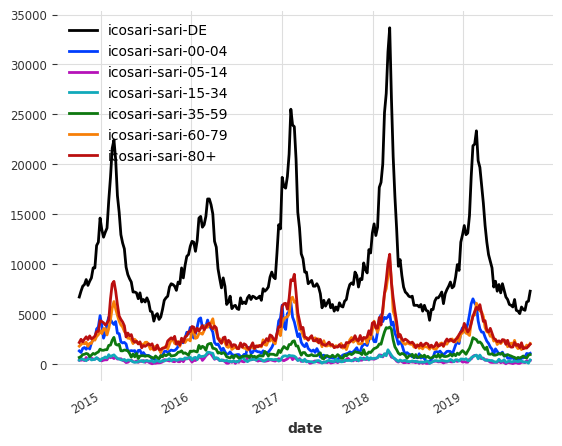

In [15]:
targets_train.plot()

In [12]:
validation_start = targets_train.end_time() + targets_train.freq

In [13]:
covariates = covariates if use_covariates else None

<Axes: xlabel='date'>

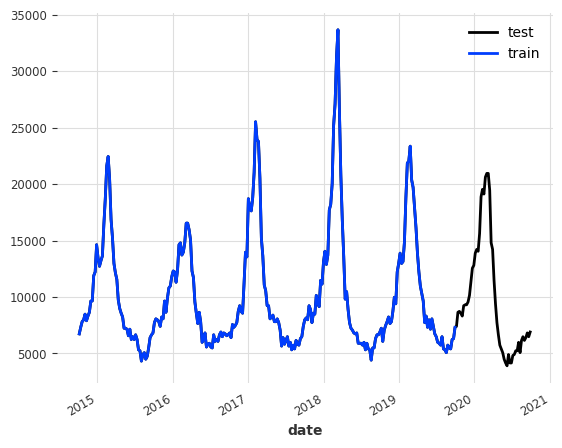

In [14]:
targets_validation['icosari-sari-DE'].plot(label='test')
targets_train['icosari-sari-DE'].plot(label='train')

# Train model

In [18]:
RANDOM_SEEDS = [1, 2, 3, 4, 5] # , 6, 7, 8, 9, 10]

In [19]:
name = 'tsmixer2'

In [ ]:
for seed in RANDOM_SEEDS:
    print(seed)
    model_path = f'../models/pre-covid/{name}-{test_year}-{seed}.pt'
    hfc_path = f'../data/pre-covid/submodels/{name}-{test_year}-{seed}.csv'
    
    model.reset_model()
    model.model_params['random_state'] = seed
    model.fit(targets_train, past_covariates=covariates)
    model.save(model_path)
    
    hfc = model.historical_forecasts(
        series=targets_validation,
        past_covariates=covariates,
        start=validation_start,
        forecast_horizon=HORIZON,
        stride=1,
        last_points_only=False,
        retrain=False,
        verbose=False,
        num_samples=NUM_SAMPLES,
        enable_optimization=True
    )
    
    df = reshape_hfc(hfc)
    df.to_csv(hfc_path, index=False)

Epoch 402/499 ━━━━━━━━━━━━╸━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10/32 0:00:00 • 0:00:01 28.59it/s train_loss: 7.047

# Compute ensemble

In [22]:
files = glob.glob(f'../data/pre-covid/submodels/{name}-{test_year}-*.csv')

In [23]:
files

['../data/pre-covid/submodels/tsmixer2-2019-5.csv',
 '../data/pre-covid/submodels/tsmixer2-2019-1.csv',
 '../data/pre-covid/submodels/tsmixer2-2019-3.csv',
 '../data/pre-covid/submodels/tsmixer2-2019-2.csv',
 '../data/pre-covid/submodels/tsmixer2-2019-4.csv']

In [37]:
dfs = [pd.read_csv(file, parse_dates=['forecast_date', 'target_end_date']) for file in files]

In [38]:
df = pd.concat(dfs)

In [26]:
df = df.groupby(['location', 'age_group', 'forecast_date', 'target_end_date', 'horizon', 'type', 'quantile']).agg({'value': 'mean'}).reset_index()

In [27]:
df.to_csv(f'../data/pre-covid/{name}_ensemble-{test_year}.csv', index=False)

In [39]:
df = df.groupby(['location', 'age_group', 'forecast_date', 'target_end_date', 'horizon', 'type', 'quantile']).agg({'value': 'median'}).reset_index()

In [40]:
df.to_csv(f'../data/pre-covid/{name}_median_ensemble-{test_year}.csv', index=False)

# Plot forecasts

In [42]:
df_plot = prepare_plot_data(df, targets_validation[validation_start : ])

### Mean ensemble

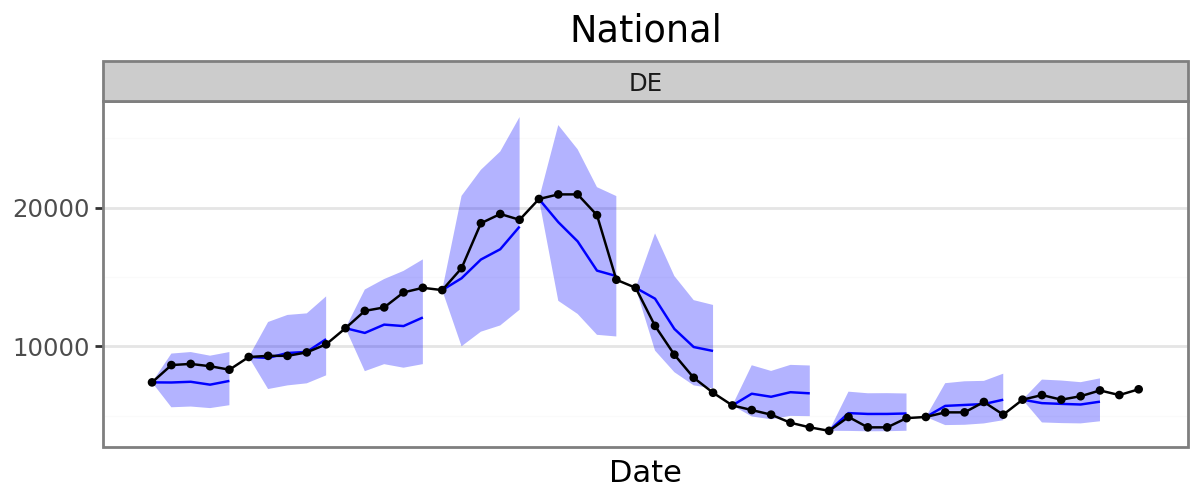

In [35]:
plot_forecasts(df_plot, 'national', start=1)

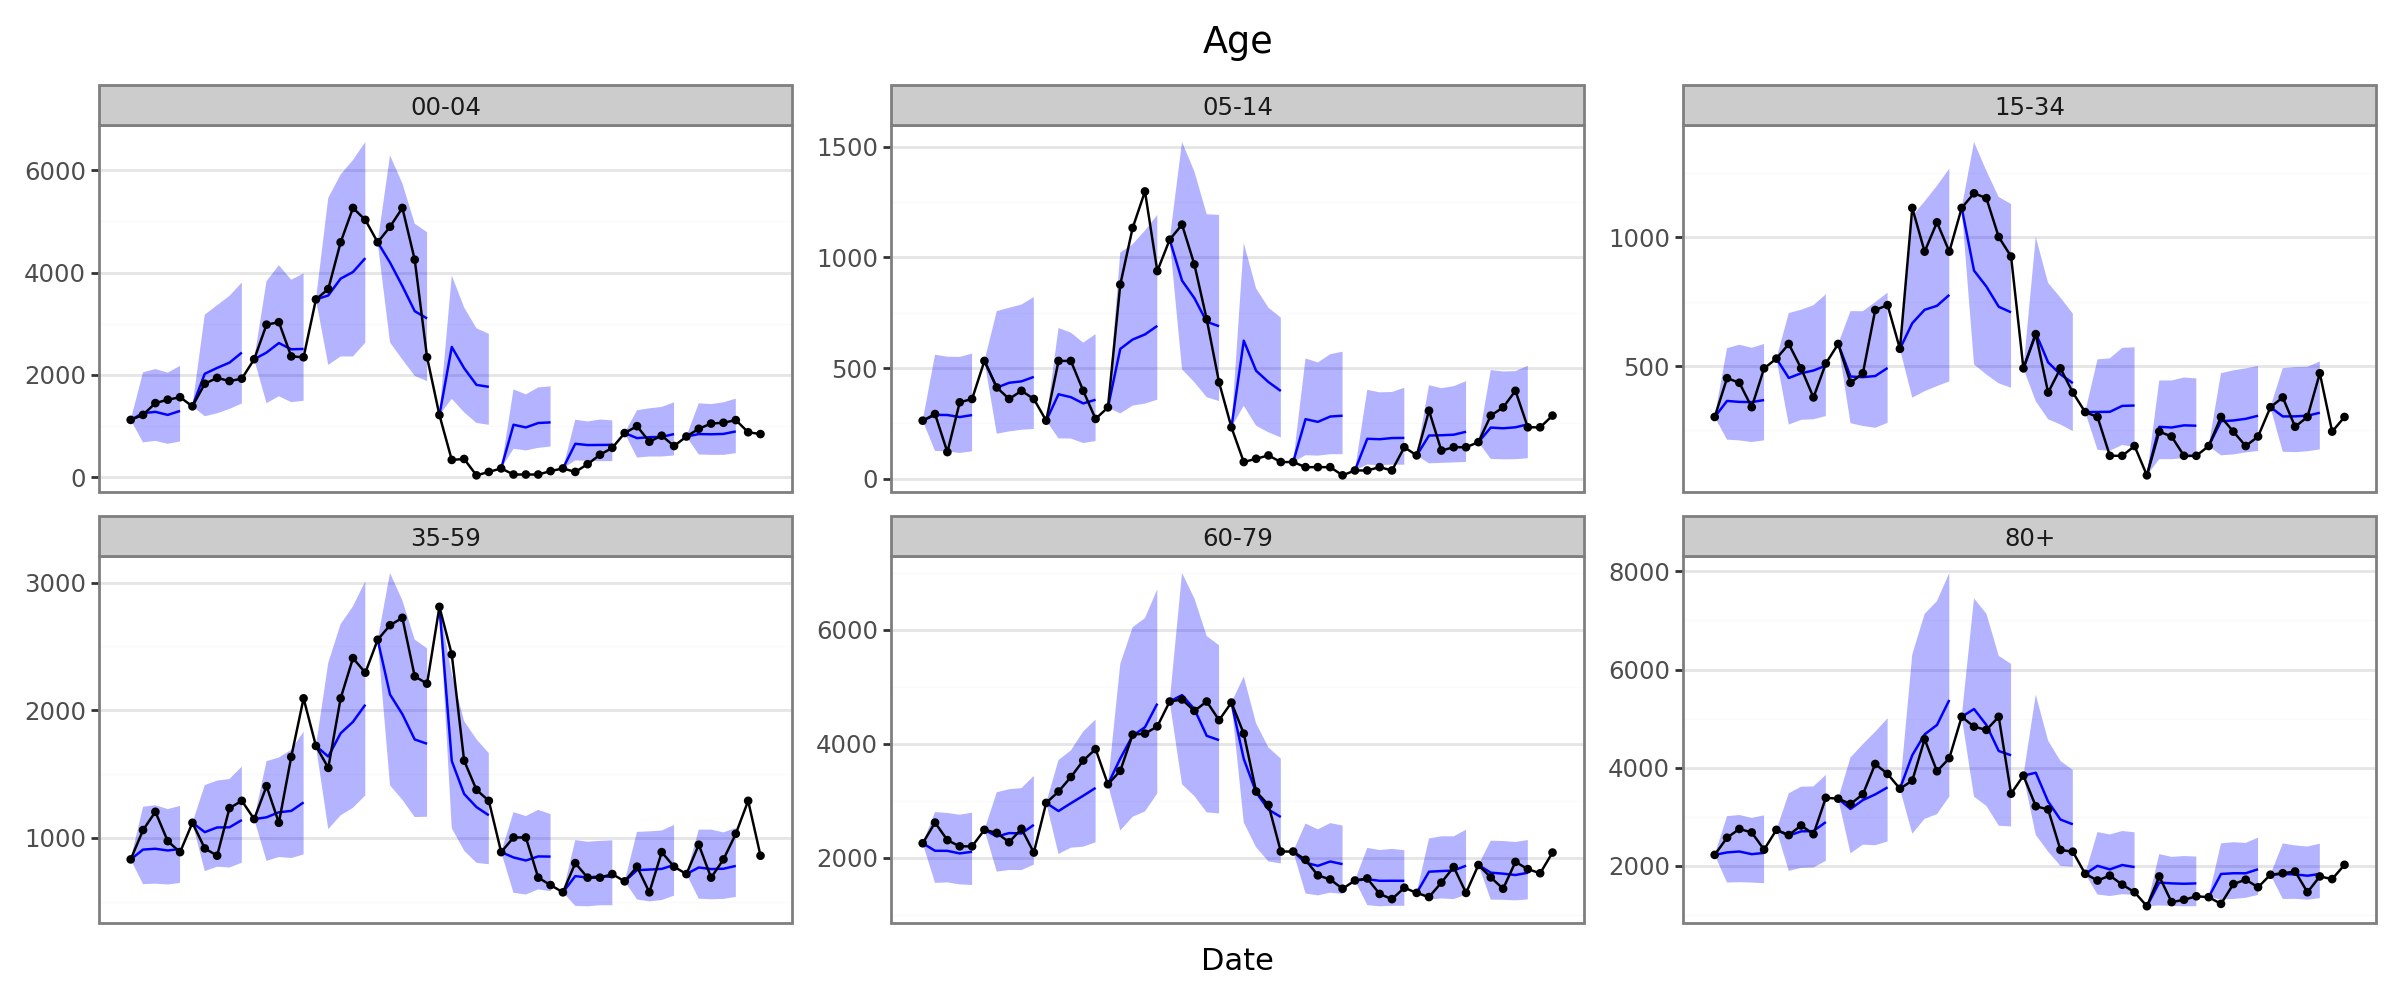

In [36]:
plot_forecasts(df_plot, 'age', start=1)

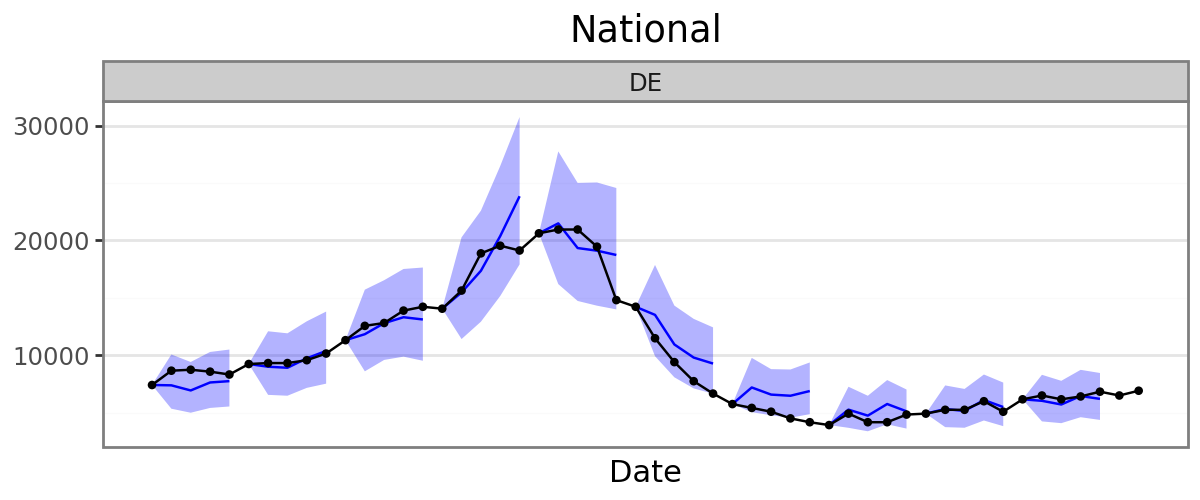

In [38]:
plot_forecasts(df_plot, 'national', start=1)

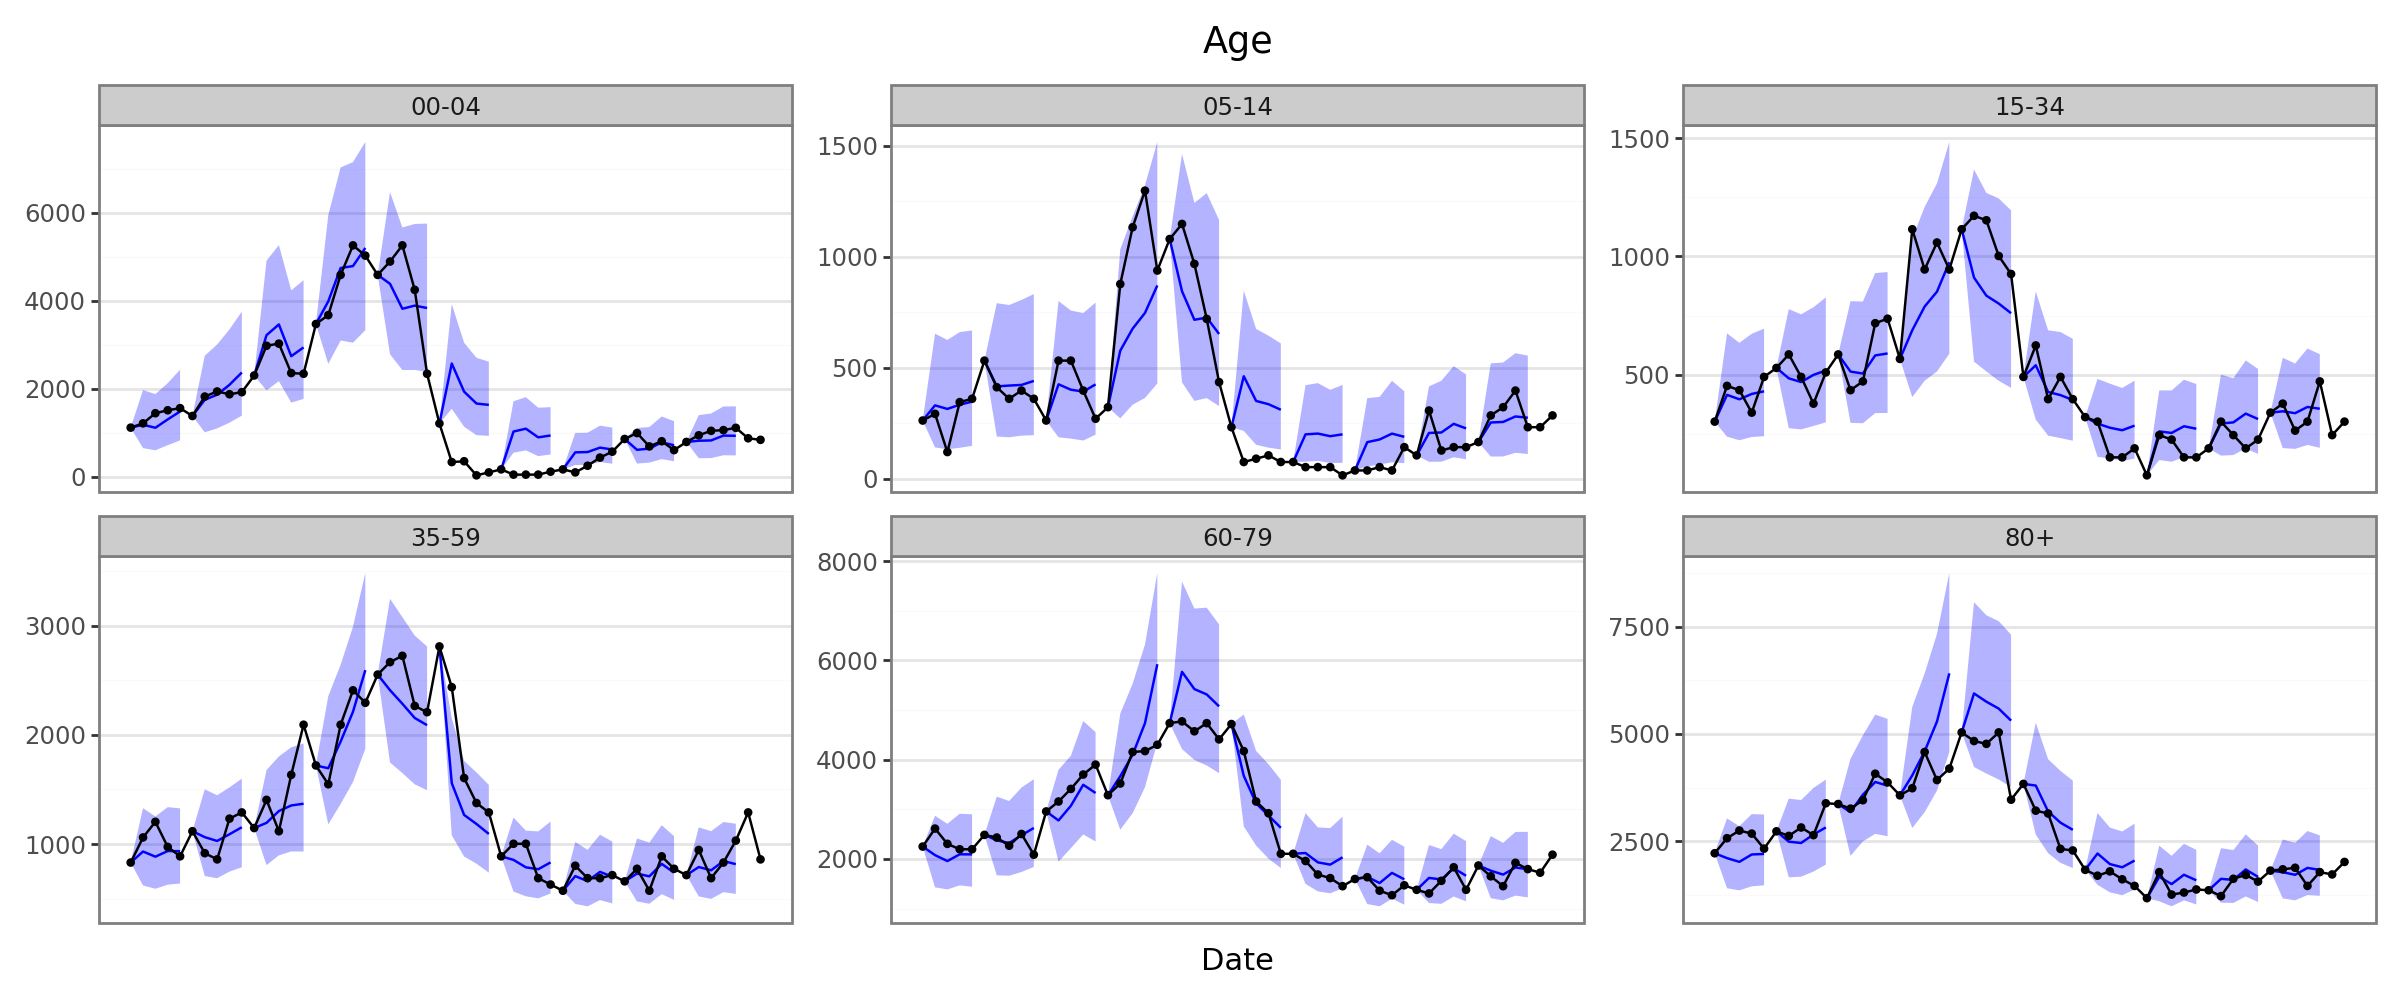

In [39]:
plot_forecasts(df_plot, 'age', start=1)

### Median ensemble

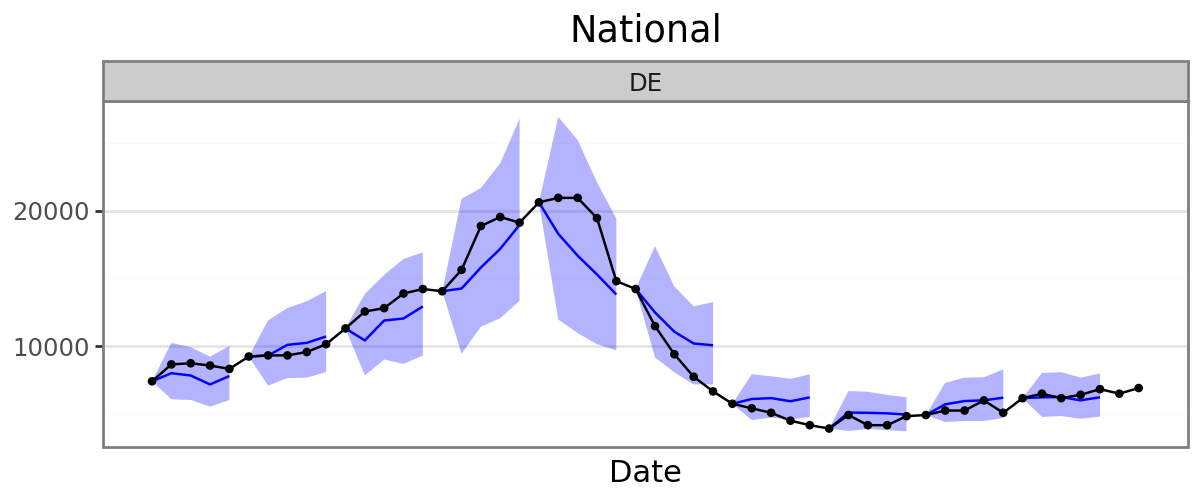

In [47]:
plot_forecasts(df_plot, 'national', start=1)

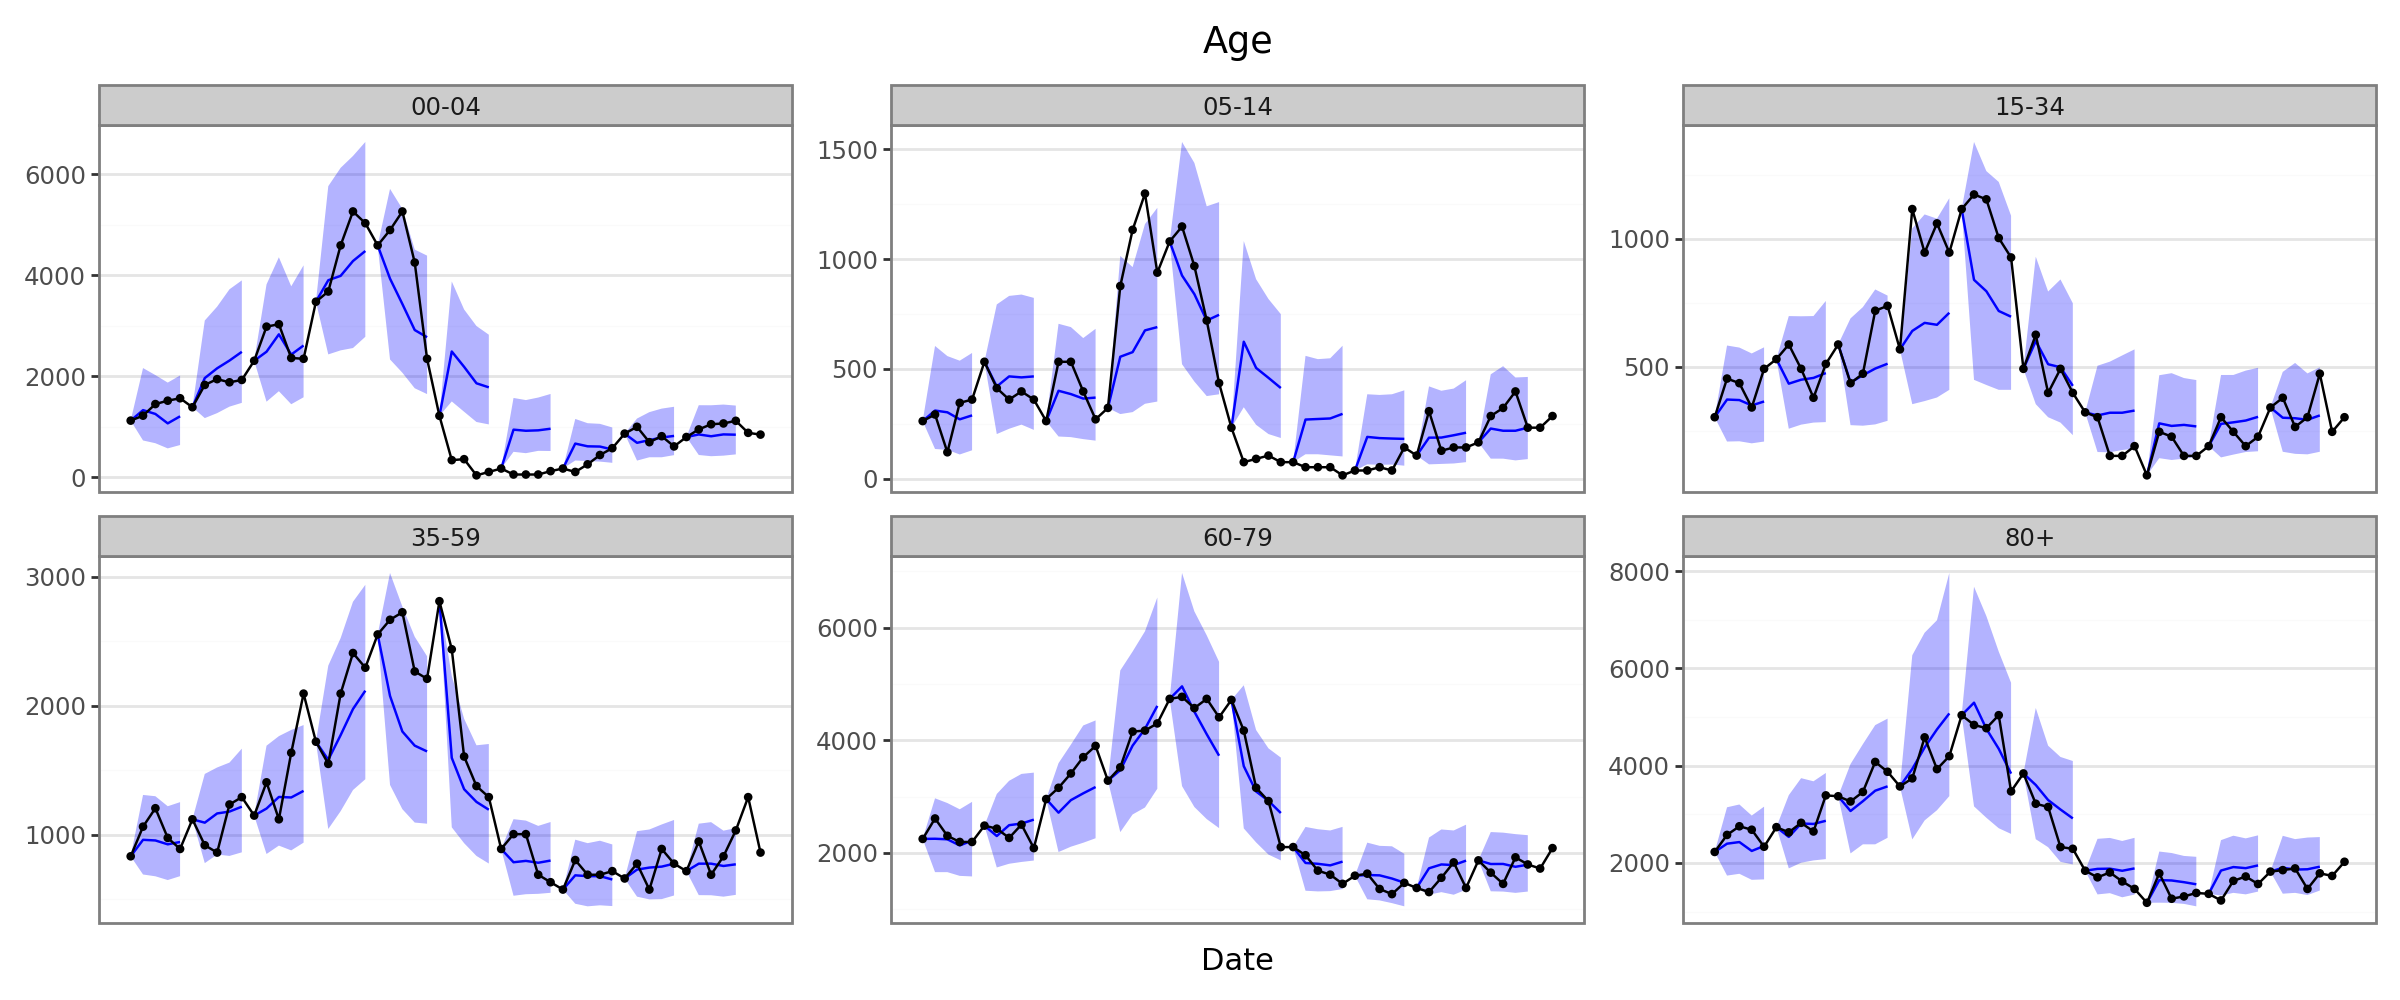

In [48]:
plot_forecasts(df_plot, 'age', start=1)

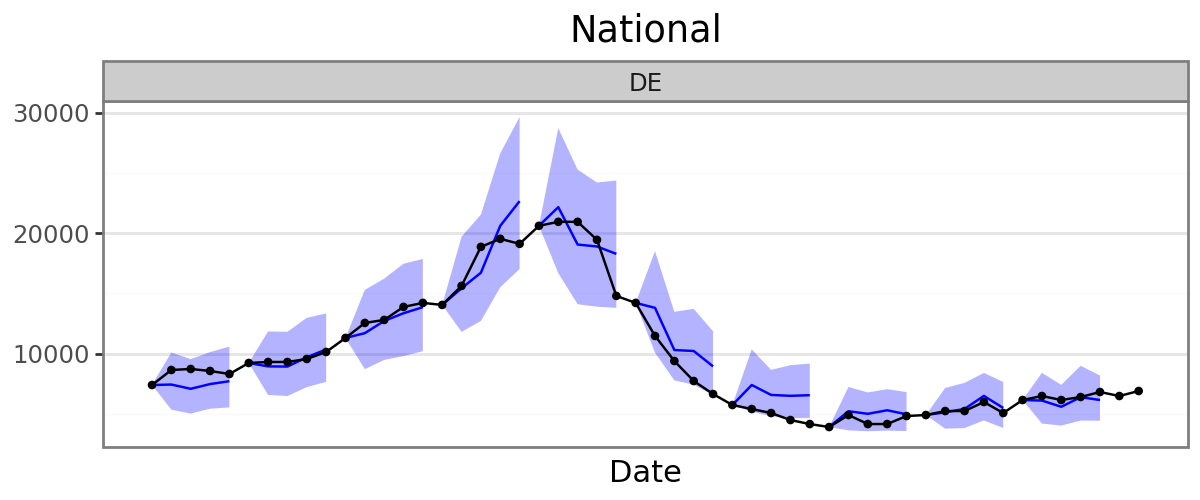

In [55]:
plot_forecasts(df_plot, 'national', start=1)

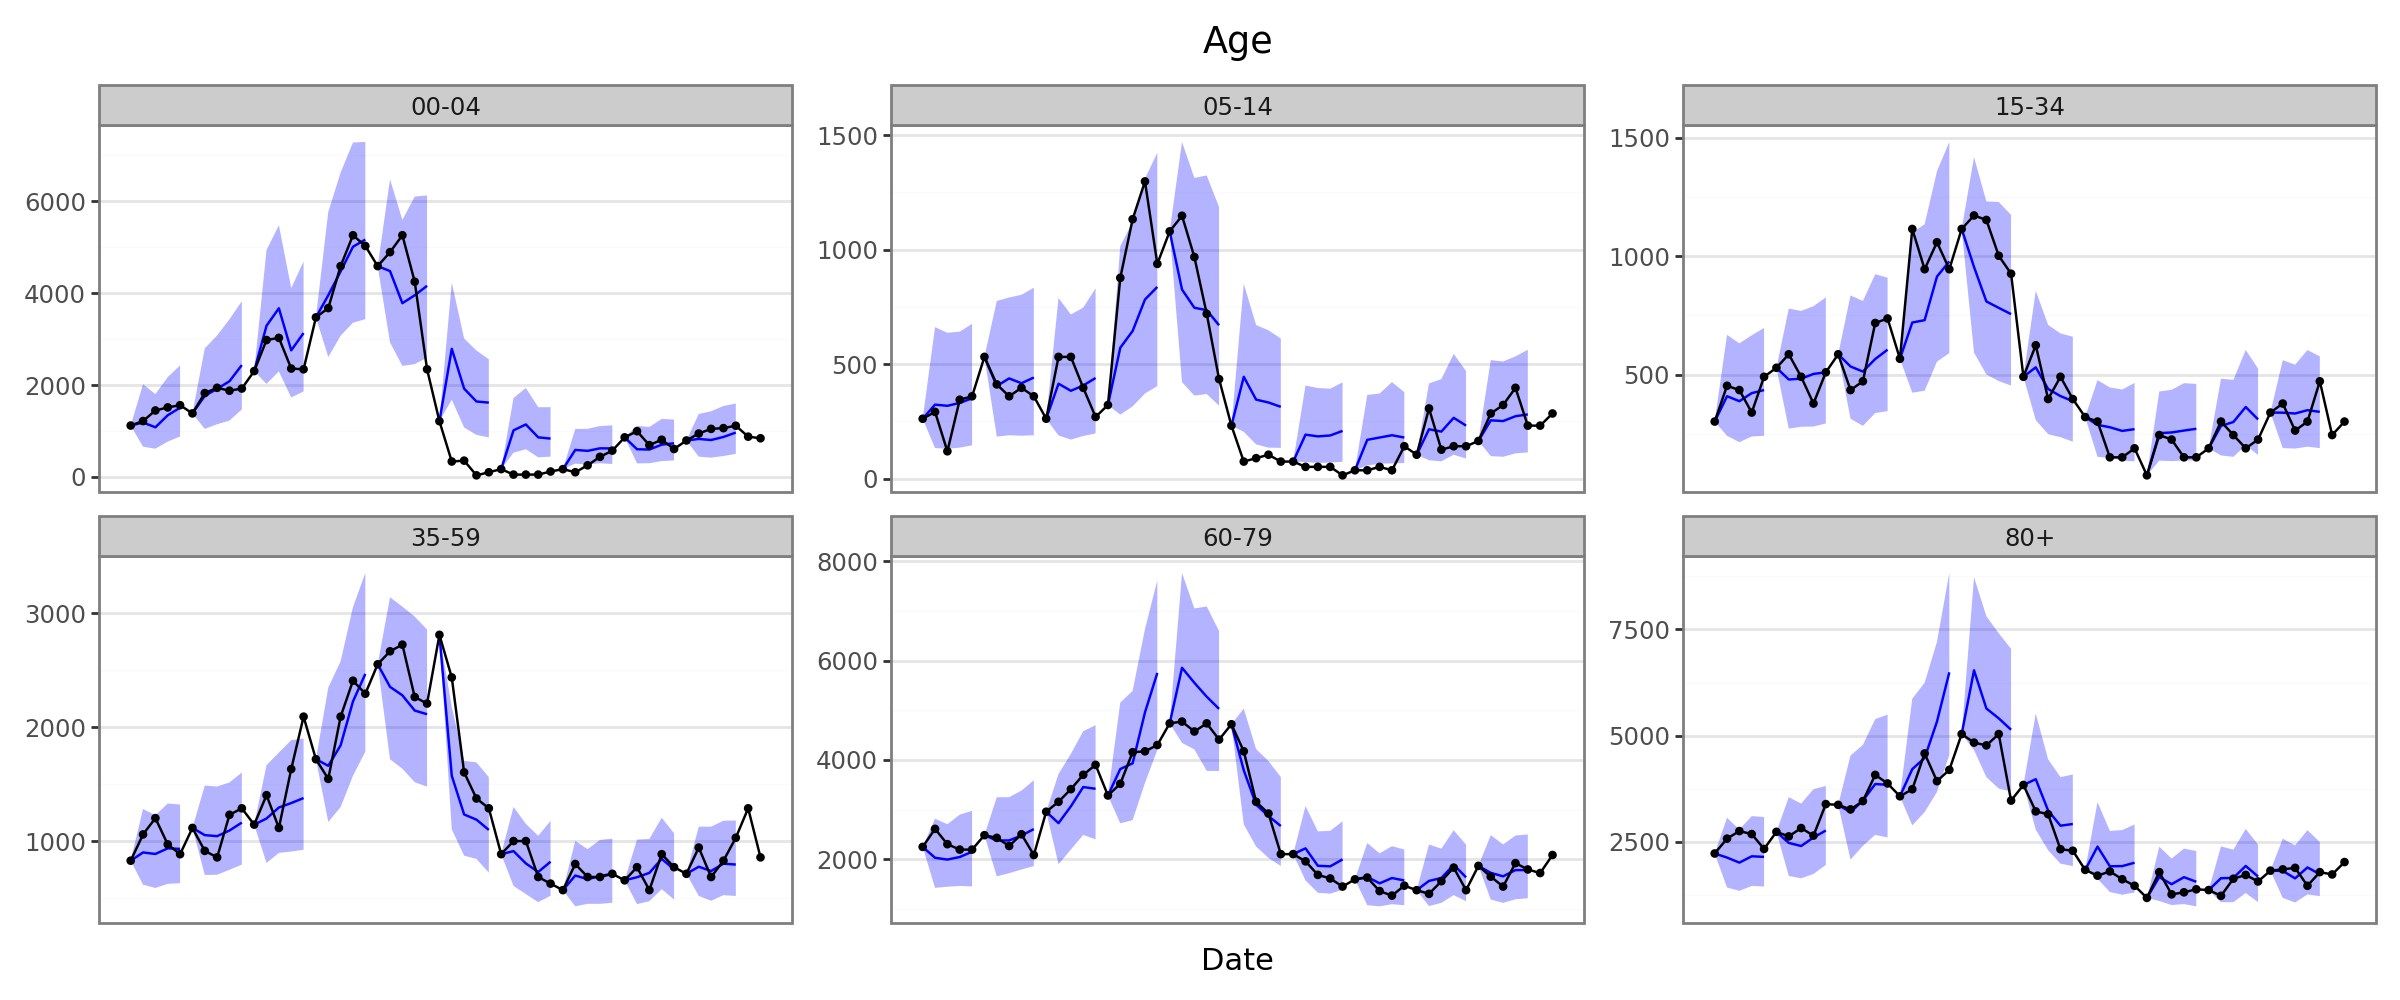

In [56]:
plot_forecasts(df_plot, 'age', start=1)